# Newton-Cotes Integration

In [15]:
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')

from parse_density_files import CUBE
import numpy as np
from matplotlib import pyplot as plt
import alchemy_tools2 as at
import scipy.integrate as intg
import alchemy_tools2 as at

def get_alchpot_vals(cube, nucleus_pos, scaled = False):
    """
    calculate \rho/|r-R|
    """
    meshgrid = cube.get_grid()
    h_matrix = cube.get_hmatrix()
    distance_nuc_grid = at.distance_MIC2(nucleus_pos, meshgrid, h_matrix) # calculate distance of gpts to nucleus with MIC
    if scaled:
        alch_pot_vals = -cube.data_scaled/distance_nuc_grid # integrate over position of electron density
    else:
        alch_pot_vals = -cube.data/distance_nuc_grid # integrate over position of electron density
    return(alch_pot_vals)

def multidim_int(f, dx, mode):
    
    I_z = np.zeros((f.shape[0], f.shape[1]))
    for i in range(f.shape[0]):
        for j in range(f.shape[1]):
            if mode == 'trapz':
                I_z[i,j] = np.trapz(f[i,j], dx = dx)
            elif mode == 'simps':
                I_z[i,j] = intg.simps(f[i,j], dx = dx)
            else:
                I_z[i,j] = nc_integration(f[i,j], dx, mode)
            
    I_yz = np.zeros(f.shape[0])
    for i in range(f.shape[0]):
        if mode == 'trapz':
            I_yz[i] = np.trapz(I_z[i], dx = dx)
        elif mode == 'simps':
            I_yz[i] = intg.simps(I_z[i], dx = dx)
        else:
            I_yz[i] = nc_integration(I_z[i], dx, mode)
    
    if mode == 'trapz':
        I_xyz = np.trapz(I_yz, dx = dx)
    elif mode == 'simps':
        I_xyz = intg.simps(I_yz, dx = dx)
    else:
        I_xyz = nc_integration(I_yz, dx, mode)
        
    return(I_xyz)

def get_composite_coeffs(order, length):
    num_ints = lambda pts_tot, pts_int: (pts_tot - 1)/(pts_int-1)
    ni = int(num_ints(length, order+1)) # number of intervals
    
    nc_coeffs = intg.newton_cotes(order, 1)[0]
    weights = np.zeros(length)
    start = 0
    for i in range(ni):
        weights[start:start+len(nc_coeffs)] = weights[start:start+len(nc_coeffs)] + nc_coeffs
        start += order
    return(weights)
    
def nc_integration(f, d, order):
    num_ints = lambda pts_tot, pts_int: (pts_tot - 1)/(pts_int-1)
    ni = int(num_ints(len(f), order+1))
    if ni == num_ints(len(f), order+1): # total interval can be divided in subintervall
        weights = get_composite_coeffs(order, len(f))
    elif len(f) == 175 and order == 4:
        weights = get_composite_coeffs(order, len(f)-2)
        weights = np.concatenate((np.array([1.0]), weights, np.array([1.0])))
        weights[1] = weights[1] + 1
        weights[-2] = weights[-2]
        
    return(np.dot(weights, f)*d)

In [2]:
# get cube files
cube_x0 = CUBE('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001212/cube-files/ve_38.cube')
cube_x5 = CUBE('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001212/shift_molecule/shift_x5/DENSITY.cube')

In [3]:
# # calculate \rho/|r-R|
alch_pot_vals_x0 = get_alchpot_vals(cube_x0, cube_x0.atoms[8][1:4])
alch_pot_vals_x5 = get_alchpot_vals(cube_x5, cube_x5.atoms[8][1:4])

#### Integral of density only

In [4]:
dens_x0_trapz = multidim_int(cube_x0.data, cube_x0.X[0], 'trapz')
dens_x0_simps = multidim_int(cube_x0.data, cube_x0.X[0], 'simps')
dens_x0_3 = multidim_int(cube_x0.data, cube_x0.X[0], 3)
dens_x0_4 = multidim_int(cube_x0.data, cube_x0.X[0], 4)

dens_x5_trapz = multidim_int(cube_x5.data, cube_x5.X[0], 'trapz')
dens_x5_simps = multidim_int(cube_x5.data, cube_x5.X[0], 'simps')
dens_x5_3 = multidim_int(cube_x5.data, cube_x5.X[0], 3)
dens_x5_4 = multidim_int(cube_x5.data, cube_x5.X[0], 4)

In [5]:
for d in [cube_x0.data_scaled.sum(), dens_x0_trapz, dens_x0_simps, dens_x0_3, dens_x0_4, cube_x5.data_scaled.sum(), dens_x5_trapz, dens_x5_simps, dens_x5_3, dens_x5_4]:
    print(f'fraction of exact density {d/38}')

fraction of exact density 1.0000040744026246
fraction of exact density 1.0000040736933486
fraction of exact density 0.9999311164428203
fraction of exact density 1.0006682659375454
fraction of exact density 1.0003577256640885
fraction of exact density 1.0000042260102469
fraction of exact density 1.0000042255143984
fraction of exact density 1.000011055807764
fraction of exact density 1.0005742133884772
fraction of exact density 1.000112351738978


trapezoidal and simple sum are most accurate for density integration?

#### Integral of alchemical potential 1D slice

In [6]:
# slice along z-axis close to selected hydrogen atom
ax1 = 0
ax2 = 1
i_ax1 = np.where(cube_x0.get_axis(ax1, 'Bohr') < cube_x0.atoms[8][ax1 + 1])[0][-1]
i_ax2 = np.where(cube_x0.get_axis(ax2, 'Bohr') < cube_x0.atoms[8][ax2+1])[0][-1]
slice_alchpot_x0 = alch_pot_vals_x0[i_ax1, i_ax2]
slice_alchpot_x5 = alch_pot_vals_x5[i_ax1, i_ax2]

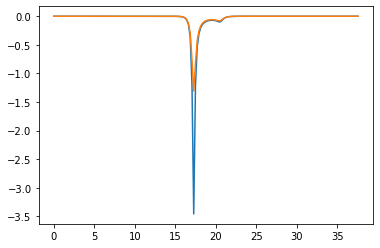

In [7]:
fig, ax =plt.subplots(1,1)
ax.plot(cube_x0.get_axis('z', 'Bohr'), slice_alchpot_x0)
ax.plot(cube_x5.get_axis('z', 'Bohr'), slice_alchpot_x5)

$\int \frac{\rho}{|\vec{r}-\vec{R}_|} d\vec{r}$

In [8]:
slice_alchpot_x0_sum = slice_alchpot_x0.sum()*cube_x0.dv
slice_alchpot_x0_trapz = np.trapz(slice_alchpot_x0, dx=cube_x0.X[0])*cube_x0.dv/cube_x0.X[0]
slice_alchpot_x0_simps = intg.simps(slice_alchpot_x0, dx=cube_x0.X[0])*cube_x0.dv/cube_x0.X[0]
slice_alchpot_x0_3 = nc_integration(slice_alchpot_x0, cube_x0.X[0], 3)*cube_x0.dv/cube_x0.X[0]
slice_alchpot_x0_4 = nc_integration(slice_alchpot_x0, cube_x0.X[0], 4)*cube_x0.dv/cube_x0.X[0]

# slice_alchpot_x5_sum = slice_alchpot_x5.sum()*cube_x5.dv
# slice_alchpot_x5_trapz = np.trapz(slice_alchpot_x5, dx=cube_x5.X[0])*cube_x5.dv/cube_x5.X[0]
# slice_alchpot_x5_simps = intg.simps(slice_alchpot_x5, dx=cube_x5.X[0])*cube_x5.dv/cube_x5.X[0]
# slice_alchpot_x5_3 = nc_integration(slice_alchpot_x5, cube_x5.X[0], 3)*cube_x5.dv/cube_x5.X[0]
# slice_alchpot_x5_4 = nc_integration(slice_alchpot_x5, cube_x5.X[0], 4)*cube_x5.dv/cube_x5.X[0]

In [9]:
for x0 in [slice_alchpot_x0_sum, slice_alchpot_x0_trapz, slice_alchpot_x0_simps, slice_alchpot_x0_3, slice_alchpot_x0_4]:
    print(f'Integral = {x0}')

Integral = -0.08781213337776426
Integral = -0.08781213337761204
Integral = -0.08222448778251071
Integral = -0.09063967354180556
Integral = -0.09484791424008554


integral similar for trapz and sum but different for simpsons

#### Integral of alchemical potential for different positions of atom to grid

In [10]:
d = cube_x0.X[0]

alchpot_x0_sum = alch_pot_vals_x0.sum()*cube_x0.dv
alchpot_x0_trapz = multidim_int(alch_pot_vals_x0, d, 'trapz')
alchpot_x0_simps = multidim_int(alch_pot_vals_x0, d, 'simps')
alchpot_x0_3 = multidim_int(alch_pot_vals_x0, d, 3)
alchpot_x0_4 = multidim_int(alch_pot_vals_x0, d, 4)

alchpot_x5_sum = alch_pot_vals_x5.sum()*cube_x5.dv
alchpot_x5_trapz = multidim_int(alch_pot_vals_x5, d, 'trapz')
alchpot_x5_simps = multidim_int(alch_pot_vals_x5, d, 'simps')
alchpot_x5_3 = multidim_int(alch_pot_vals_x5, d, 3)
alchpot_x5_4 = multidim_int(alch_pot_vals_x5, d, 4)

In [11]:
labels = ['sum', 'trapz', 'simps', '3rd', '4th']
Intsx0 = [alchpot_x0_sum, alchpot_x0_trapz, alchpot_x0_simps, alchpot_x0_3, alchpot_x0_4]
Intsx5 = [alchpot_x5_sum, alchpot_x5_trapz, alchpot_x5_simps, alchpot_x5_3, alchpot_x5_4]
for l, Ix0, Ix5 in zip(labels, Intsx0, Intsx5):
    print(f'Difference x0 - x5 {l} = {Ix0 - Ix5}')

Difference x0 - x5 sum = 0.047354149156246805
Difference x0 - x5 trapz = 0.04735414974546792
Difference x0 - x5 simps = 0.005314932985150733
Difference x0 - x5 3rd = 0.058743759112022786
Difference x0 - x5 4th = 0.16844200050474356


- difference between alchemical reduced by one order of magnitude if simpsons rule is used
- no improvement from sum to trapz due to symmetry induced error cancelling for sum?
- performance worse than simple sum for 3rd, 4th order integration, bug or numerical instabilities?

#### test imported function

In [12]:
d = cube_x0.X[0]
at.multidim_int(alch_pot_vals_x0, d, 'simps') - multidim_int(alch_pot_vals_x0, d, 'simps')

0.0

In [16]:
at.calculate_atomic_energies(cube_x0.data, cube_x0.atoms, cube_x0.get_grid(), cube_x0.get_hmatrix(), 'simps')

(array([-34.38039525, -37.38711605, -69.80815037, -72.36988238,
        -36.00848169, -33.7852654 , -45.20171939,  -3.25516652,
         -3.2976341 ,  -3.30474488,  -3.57608902,  -3.59659828]),
 array([ -63.0728019 ,  -76.1398462 , -107.79222541, -117.6171008 ,
         -71.23273889,  -65.63292175,  -72.78607363,   -8.24653492,
          -8.45130533,   -8.45839683,   -9.52570972,   -9.54604483]),
 array([-10.51213365, -12.68997437, -13.47402818, -14.7021376 ,
        -11.87212315, -10.93882029, -10.39801052,  -8.24653492,
         -8.45130533,  -8.45839683,  -9.52570972,  -9.54604483]))

In [17]:
at.calculate_atomic_energies(cube_x5.data, cube_x5.atoms, cube_x5.get_grid(), cube_x5.get_hmatrix(), 'simps')

(array([-34.37478848, -37.38122444, -69.90713594, -72.35398684,
        -36.00770281, -33.79446988, -45.22515736,  -3.24146593,
         -3.30294903,  -3.30725314,  -3.5676475 ,  -3.6066488 ]),
 array([ -63.06719512,  -76.13395456, -107.89121087, -117.60120534,
         -71.23196035,  -65.64212639,  -72.8095117 ,   -8.23283433,
          -8.45662027,   -8.4609051 ,   -9.51726876,   -9.55609535]),
 array([-10.51119919, -12.68899243, -13.48640136, -14.70015067,
        -11.87199339, -10.9403544 , -10.40135881,  -8.23283433,
         -8.45662027,  -8.4609051 ,  -9.51726876,  -9.55609535]))

In [20]:
res0 = np.array([-10.51213365, -12.68997437, -13.47402818, -14.7021376 ,
        -11.87212315, -10.93882029, -10.39801052,  -8.24653492,
         -8.45130533,  -8.45839683,  -9.52570972,  -9.54604483])
res5 = np.array([-10.51119919, -12.68899243, -13.48640136, -14.70015067,
        -11.87199339, -10.9403544 , -10.40135881,  -8.23283433,
         -8.45662027,  -8.4609051 ,  -9.51726876,  -9.55609535])

In [23]:
np.abs(res0-res5)

array([0.00093446, 0.00098194, 0.01237318, 0.00198693, 0.00012976,
       0.00153411, 0.00334829, 0.01370059, 0.00531494, 0.00250827,
       0.00844096, 0.01005052])

In [24]:
cube_x0.atoms

array([[ 6.      , 19.979529, 22.784627, 18.908058],
       [ 6.      , 20.35982 , 19.964565, 18.890009],
       [ 8.      , 22.344159, 18.857926, 18.863323],
       [ 8.      , 18.092893, 18.74945 , 18.905025],
       [ 6.      , 18.285827, 16.053484, 18.887816],
       [ 6.      , 15.726597, 15.015175, 18.906865],
       [ 7.      , 13.735016, 14.125508, 18.920052],
       [ 1.      , 21.813395, 23.718436, 18.8968  ],
       [ 1.      , 18.878631, 23.358359, 17.25609 ],
       [ 1.      , 18.90752 , 23.341078, 20.584704],
       [ 1.      , 19.30598 , 15.408752, 17.207074],
       [ 1.      , 19.337767, 15.389776, 20.541321]])

#### test higher order integration

In [13]:
# slice along z-axis close to selected hydrogen atom
ax1 = 0
ax2 = 1
i_ax1 = np.where(cube_x0.get_axis(ax1, 'Bohr') < cube_x0.atoms[8][ax1 + 1])[0][-1]
i_ax2 = np.where(cube_x0.get_axis(ax2, 'Bohr') < cube_x0.atoms[8][ax2+1])[0][-1]
slice_alchpot_x0 = alch_pot_vals_x0[i_ax1, i_ax2]
d = cube_x0.X[0]

In [14]:
print(nc_integration(slice_alchpot_x0, d, 1) - np.trapz(slice_alchpot_x0,dx=d))
print(nc_integration(slice_alchpot_x0, d, 2) - intg.simps(slice_alchpot_x0,dx=d))

-4.440892098500626e-16
2.220446049250313e-16


integrals agree for trapezoidal and simpsons rule

# Calculation of the second derivative between two points

In [ ]:
import matplotlib
matplotlib.use('Qt5Agg')
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 22})
import numpy as np

second derivative at x = 0.5 is according to finite difference scheme
\begin{equation}
    f''(x_i) = \frac{ f_{i+1} - 2 f_i + f_{i-1} }{h}
\end{equation}

$f_i$ is unkown. We estimate it by linear interpolation between $x_{i+1}, x_{i-1}$.
$ m = \frac{f_{i+1}-f_{i-1}}{x_{i+1} - x_{i-1}} $ but the second derivative of a first order polynomial is zero therefore this is not helpful

Instead we can use the average of the second derivatives of the enclosing points. The motivation is, that these values should become more similiar as the points come closer together.


In [ ]:
def linear_eq(x, y):
    m = (y[1]-y[0])/(x[1]-x[0])
    b = y[0] - m*x[0]
    return(m,b)

def d2_finite_diff(x,y):
    return((y[2] - 2*y[1] + y[0])/((x[2]-x[1])**2))

def predictor(x):
    x_vals = np.array([x-0.2, x, x+0.2])
    y_vals = np.exp(x_vals)
    return(x_vals, y_vals)

In [ ]:
x_1 = np.array([0.3, 0.4, 0.5])
y_1 = np.exp(x_1)
d2_finite_diff(x_1, y_1)

In [ ]:
x_2 = np.array([0.4, 0.5, 0.6])
y_2 = np.exp(x_2)
d2_finite_diff(x_2, y_2)

In [ ]:
(d2_finite_diff(x_1, y_1) + d2_finite_diff(x_2, y_2))/2

In [ ]:
np.exp(0.5)

In [ ]:
for i in [0.2, 0.4, 0.6]:
    x1,y1 = predictor(i)
    x2, y2 = predictor(i+0.2)
    print('Second derivative at x = {}'.format(i+0.1))
    f1 = d2_finite_diff(x1,y1)
    f2 = d2_finite_diff(x2,y2)
    mf = (f2+f1)/2
    print(mf)
    
    print(np.exp(i+0.1))
    print('Error = {}'.format(np.abs(mf-np.exp(i+0.1))))

In [ ]:
x_exact = np.linspace(0, 1, 100)
f_exact = np.exp(x_exact)

x_calc = np.linspace(0, 1, 6)
f_calc = np.exp(x_calc)

fig, ax = plt.subplots(1,1)
ax.plot(x_exact, f_exact)
ax.scatter(x_calc, f_calc)